In [32]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as si
import os 

In [2]:
df = yf.download("BAC", start="2020-03-01", end="2021-03-01")

[*********************100%***********************]  1 of 1 completed


In [3]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-03-02,28.350000,29.379999,27.440001,29.370001,28.461542,147776300
2020-03-03,29.370001,29.750000,27.620001,27.750000,26.891647,138698500
2020-03-04,28.250000,28.420000,27.400000,28.389999,27.511854,111239800
2020-03-05,27.240000,27.350000,26.400000,26.780001,26.117243,110878700
2020-03-06,25.469999,26.209999,25.100000,25.709999,25.073723,119121200


In [7]:
df['Adj Close'].head()

Date
2020-03-02    28.461542
2020-03-03    26.891647
2020-03-04    27.511854
2020-03-05    26.117243
2020-03-06    25.073723
Name: Adj Close, dtype: float64

In [21]:
da = df['Adj Close']
da.describe().round(2)

count    251.00
mean      25.70
std        3.75
min       17.63
25%       23.29
50%       24.65
75%       28.23
max       36.20
Name: Adj Close, dtype: float64

In [11]:
da.head()

Date
2020-03-02    28.461542
2020-03-03    26.891647
2020-03-04    27.511854
2020-03-05    26.117243
2020-03-06    25.073723
Name: Adj Close, dtype: float64

<AxesSubplot:xlabel='Date'>

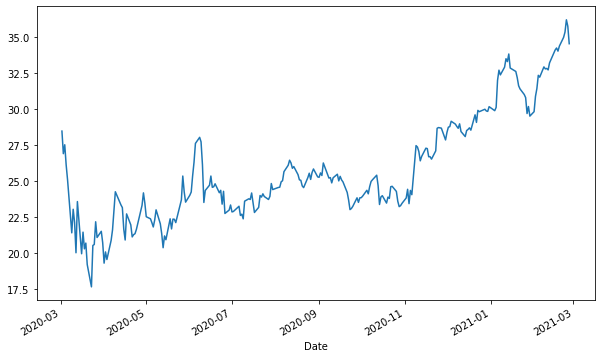

In [20]:
da.plot(figsize=(10, 6))

In [23]:
da.diff().head().round(2)

Date
2020-03-02     NaN
2020-03-03   -1.57
2020-03-04    0.62
2020-03-05   -1.39
2020-03-06   -1.04
Name: Adj Close, dtype: float64

In [24]:
da.pct_change().round(4).head()

Date
2020-03-02       NaN
2020-03-03   -0.0552
2020-03-04    0.0231
2020-03-05   -0.0507
2020-03-06   -0.0400
Name: Adj Close, dtype: float64

In [25]:
logda = np.log(da / da.shift(1))
logda.head().round(4)

Date
2020-03-02       NaN
2020-03-03   -0.0567
2020-03-04    0.0228
2020-03-05   -0.0520
2020-03-06   -0.0408
Name: Adj Close, dtype: float64

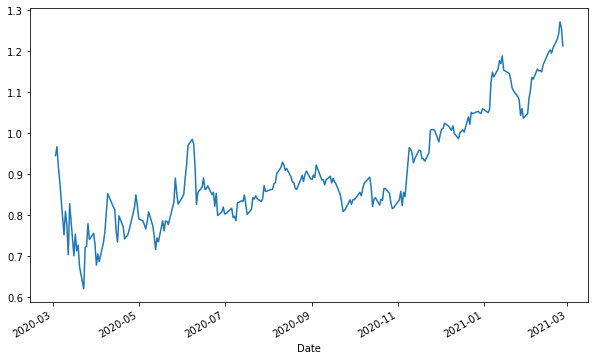

In [26]:
 logda.cumsum().apply(np.exp).plot(figsize=(10, 6));

In [27]:
nr = logda.mean() * 252
vol = logda.std() * (252 ** 0.5)
print('The annulized normal return is %.8f and its one year annulized volatility is %.8f' % (nr,vol))

The annulized normal return is 0.19506753 and its one year annulized volatility is 0.58882265


In [29]:
sixlr = logda[126:-1]


In [30]:
sixnr = sixlr.mean() * 252
sixvol = sixlr.std() * (252 ** 0.5)
print('The annulized normal return is %.8f and its six months  annulized volatility is %.8f' % (nr,sixvol))

The annulized normal return is 0.19506753 and its six months  annulized volatility is 0.35799659


In [73]:
def mcs_simulation_np(p):
    M = p
    I = p
    dt = T / M 
    S = np.zeros((M + 1, I))
    S[0] = S0 
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, M + 1): 
        S[t] = S[t-1] * np.exp((r - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * rn[t]) 
    return S

In [74]:
T = 4/52
r = 0.0151
sigma = 0.5888
S0 = 36.9
K = 39.0

In [75]:
S = mcs_simulation_np(1000)

In [76]:
S = np.transpose(S)
S

array([[36.9       , 37.23870304, 37.53791594, ..., 36.39159906,
        36.66633668, 36.70429382],
       [36.9       , 36.85125111, 36.92817202, ..., 30.28279623,
        29.96431619, 30.00438346],
       [36.9       , 36.66087533, 36.65045515, ..., 40.6648098 ,
        40.58789373, 40.65580406],
       ...,
       [36.9       , 36.68088871, 36.64589093, ..., 31.84017826,
        31.6989634 , 31.90269205],
       [36.9       , 37.05955982, 37.58673451, ..., 44.85289972,
        45.00258832, 44.50389186],
       [36.9       , 36.91818327, 36.87029696, ..., 36.33449675,
        36.41565294, 36.22469566]])

Text(0.5, 1.0, 'Frequency distribution of the simulated end-of-preiod values')

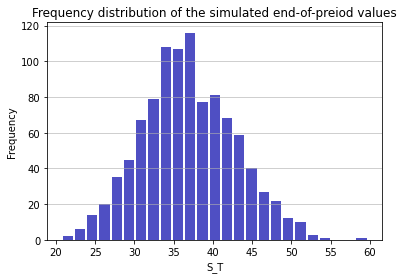

In [77]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(x=S[:,-1], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('S_T')
plt.ylabel('Frequency')
plt.title('Frequency distribution of the simulated end-of-preiod values')

In [78]:
pp = (K - S[-1,:])>0
bpp = np.mean(np.maximum(pp.astype(int),0))
print('Binary put', str(bpp))

Binary put 0.8241758241758241


In [81]:
def binary_option_bsm(S, K, T, r, q, vol, payoff):
    
    #Sa: spot price
    #K: strike price
    #T: time to maturity
    #r: risk free rate
    #q: continuous dividend yield
    #vol: volatility of underlying asset
    #payoff: call or put
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        option_value = S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        option_value =  - S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return option_value

In [82]:
binary_option_bsm(36.9,39,4/52,0.0151,0.0187,0.5888,'put')


3.661702093736146

In [ ]:
#BINOMIAL TREE

In [52]:
import random
from math import exp, sqrt

def gbm(Sb, v, r, T):
    return Sb * exp((r - 0.5 * v**2) * T + v * sqrt(T) * random.gauss(0,1.0))

def binary_call_payoff(K, S_T):
    if K >= S_T:
        return 1.0
    else:
        return 0.0

# parameters
Sb = 36.9 # asset price
v = 0.5888 # vol of 20%
r = 0.0151 # rate of 1%
maturity = 4/52
K = 39.0 # ATM strike
simulations = 10000
payoffs = 0.0

# run simultaion
for i in range(simulations):
    S_T = gbm(Sb, v, r, maturity)
    payoffs += binary_put_payoff(K, S_T)

# find prices
option_price = exp(-r * maturity) * (payoffs / float(simulations))

option_price

0.6577355709658845

In [ ]:
#BlackScholes Model 2 

In [61]:
from scipy.stats import norm
from math import exp, log, sqrt
S, K, v, r, T = 36.9, 39.0, 0.5888, 0.0151, 4/52
d2 = (log(S/K) + (r - 0.5 * v**2) * T) / v*sqrt(T)
pp = exp(-r * T) * norm.cdf(-d2)
pp

0.5120914800868395

In [ ]:
#GREEKS

In [94]:
#DELTA

In [103]:
def delta(S0,k,T,r,q,vol,payoff):
    d1 = (np.log(S0/k) + (r + 0.5 * vol **2)*T)/(vol * np.sqrt(T))
    d2 = (np.log(S0/k) + (r - 0.5 * vol **2)*T)/(vol * np.sqrt(T))
    
    if payoff == 'call':
        delta =  (np.exp(-r*T))*si.norm.pdf(d2,0.0,1.0)/(vol*S0*np.sqrt(T))
    elif payoff == 'put':
        delta = -(np.exp(-r*T)*si.norm.pdf(d2,0.0,1.0))/(vol*S0*np.sqrt(T))

    return delta

In [104]:
delta(36.9,39,4/52,0.0151,0.0187,0.5888,'put')

-0.06070977615615771

In [105]:
#GAMMA

In [108]:
def gamma(S0,k,T,r,q,vol,payoff):
    d1 = (np.log(S0/k) + (r + 0.5 * vol **2)*T)/(vol * np.sqrt(T))
    d2 = (np.log(S0/k) + (r - 0.5 * vol **2)*T)/(vol * np.sqrt(T))
    
    if payoff == 'call':
        gamma = (np.exp(-r*T)*d1*si.norm.pdf(d2,0.0,1.0))/((vol**2)*(S0**2)*(T))
    elif payoff == 'put':
        gamma = -(np.exp(-r*T)*d1*si.norm.pdf(d2,0.0,1.0))/((vol**2)*(S0**2)*(T))

    return gamma

In [109]:
gamma(36.9,39,4/52,0.0151,0.0187,0.5888,'put')

0.0025204606873093084

In [110]:
#THETA

In [111]:
def theta(S0,k,T,r,q,vol,payoff):
    d1 = (np.log(S0/k) + (r + 0.5 * vol **2)*T)/(vol * np.sqrt(T))
    d2 = (np.log(S0/k) + (r - 0.5 * vol **2)*T)/(vol * np.sqrt(T))
    a = d1/(2*T)
    b = (r-q)/(vol*np.sqrt(T))
    if payoff == 'call':
        theta = (r* np.exp(-r*T)*(si.norm.cdf(d2,0.0,1.0)))+(np.exp(-r*T)*si.norm.pdf(d2,0.0,1.0))* (a-b)
    elif payoff == 'put':
        theta = (r* np.exp(-r*T)*(1- si.norm.cdf(d2,0.0,1.0)))-(np.exp(-r*T)*si.norm.pdf(d2,0.0,1.0))* (a-b)

    return theta

In [112]:
theta(36.9,39,4/52,0.0151,0.0187,0.5888,'put')

0.5967875451065687

In [113]:
#SPEED

In [114]:
def speed(S0,k,T,r,q,vol,payoff):
    d1 = (np.log(S0/k) + (r + 0.5 * vol **2)*T)/(vol * np.sqrt(T))
    d2 = (np.log(S0/k) + (r - 0.5 * vol **2)*T)/(vol * np.sqrt(T))
    a= (np.exp(-r*T)*si.norm.pdf(d2,0.0,1.0))/((vol**2)*(S0**3)*(T))
    b= ((-2*d1)+((1-(d1*d2))/(vol*np.sqrt(T))))
    
    if payoff == 'call':
        speed = -a*b
    elif payoff == 'put':
        speed = a*b

    return speed

In [115]:
speed(36.9,39,4/52,0.0151,0.0187,0.5888,'put')

0.0016355772268741068

In [116]:
#VEGA

In [117]:
def vega(S0,k,T,r,q,sig,payoff):
    d1 = (np.log(S0/k) + (r + 0.5 * sig **2)*T)/(sig * np.sqrt(T))
    d2 = (np.log(S0/k) + (r - 0.5 * sig **2)*T)/(sig * np.sqrt(T))
    a = (np.sqrt(T) + ((d2)/sig))   
    if payoff == 'call':
        vega = (-np.exp(-r*T)*si.norm.pdf(d2,0.0,1.0)) * a
    elif payoff == 'put':
        vega = (np.exp(-r*T)*si.norm.pdf(d2,0.0,1.0)) * a
            
    return vega

In [119]:
vega(36.9,39,4/52,0.0151,0.0187,0.5888,'put')

-0.15543796767170215